In [40]:
import torch
import torch.nn.functional as F

criterion = torch.nn.BCEWithLogitsLoss()
pred = torch.rand([256, 10])
num_classes = 10
target = torch.randint(0, 9, (256,))
target = F.one_hot(target, num_classes).float()
criterion(pred, target)

tensor(0.9365)

In [1]:
"BCEWithLogitsLoss".lower()

'bcewithlogitsloss'

In [6]:
import os

for d in os.listdir('./outputs/dataset=MNIST/FSW/EER'):
    print(d.split("_"))
    break

['seed=10', 'model=MLP', 'epoch=1', 'lr=0.001', 'tau=1.0', 'alpha=0.0005', 'lmbd=1.0', 'lmbdold=0.0']


In [12]:
import numpy as np

def is_number(value):
    flag=True
    try:
        num=float(value)
        flag = num == num
    except ValueError:
        flag=False
    return flag

In [17]:
runs = list()
for d in os.listdir('./outputs/dataset=MNIST/FSW/EER'):
    info_dict = dict()
    info_dict['path'] = d
    for elem in d.split("_"):
        k, v = elem.split("=")
        info_dict[k] = int(v) if v.isdigit() else float(v) if is_number(v) else v
        info_dict['path'] = d
    runs.append(info_dict)


In [15]:
import torch
import numpy as np

class_idx = [8, 2, 4, 1, 5, 6, 7, 0, 3, 9]


In [18]:
from cl_gym.benchmarks.base import SplitDataset

class SplitDataset1(SplitDataset):
    def __init__(self, task_id, num_classes_per_split, dataset, class_idx = None):
        self.task_id = task_id
        self.num_classes_per_split = num_classes_per_split
        self.dataset = dataset
        if isinstance(dataset.targets, np.ndarray):
            original_target = dataset.targets
        elif isinstance(dataset.targets, list):
            original_target = np.asarray(dataset.targets)
        # for MNIST-like datasets where targets are tensors
        else:
            original_target = dataset.targets.clone().detach().numpy()
        self.original_target = original_target
        self.class_idx = np.unique(original_target) if class_idx is None else class_idx
        self.build_split(task_id)
        self.sample_weight = torch.ones(self.__len__()) #ADDED - for dtype agreement
    
    def update_weight(self, sample_weight):
        self.sample_weight = sample_weight

    def build_split(self, task_id):
        target_classes = list()
        if isinstance(task_id, int):
            task_id = [task_id]
        for task in task_id:
            start_class = (task-1) * self.num_classes_per_split
            end_class = min(task * self.num_classes_per_split, len(self.class_idx))
            target_classes += self.class_idx[start_class:end_class]
        indices = np.zeros_like(self.original_target)
        for c in target_classes:
            indices = np.logical_or(indices, self.original_target == c)
        self.true_index = np.where(indices)[0] 
        self.targets = self.original_target[self.true_index]

    def __getitem__(self, index: int):
        idx = self.true_index[index]
        img, target, *_ = self.dataset[idx]
        if isinstance(self.task_id, int):
            task_id = self.task_id
        else:
            task_id = self.class_idx.index(target) // self.num_classes_per_split + 1
        sample_weight = self.sample_weight[index]
        return img, target, task_id, index, sample_weight
    
    def __len__(self):
        return len(self.true_index)



In [26]:
from cl_gym.benchmarks.utils import DEFAULT_DATASET_DIR
import torchvision

trains = dict()
mnist_train = torchvision.datasets.MNIST(DEFAULT_DATASET_DIR, train=True, download=True)
trains[2] = SplitDataset1([1, 2], 2, mnist_train, class_idx=class_idx)

In [37]:
trains[2][8]

(<PIL.Image.Image image mode=L size=28x28>, 8, 1, 8, tensor(1.))

In [7]:
import numpy as np
from numpy import array
class_acc={3: array([ 542, 1000]), 8: array([ 783, 1000]), 0: array([ 687, 1000]), 6: array([ 802, 1000]), 1: array([ 865, 1000]), 9: array([ 825, 1000]), 5: array([ 560, 1000]), 7: array([ 766, 1000]), 4: array([ 400, 1000]), 2: array([ 397, 1000])}

class_acc1={0: array([ 281, 1000]), 1: array([ 449, 1000])}
class_acc1.update({3: array([ 297, 1000]), 2: array([ 235, 1000])})
class_acc1.update({5: array([ 223, 1000]), 4: array([ 175, 1000])})
class_acc1.update({6: array([ 470, 1000]), 7: array([ 419, 1000])})
class_acc1.update({8: array([ 364, 1000]), 9: array([ 466, 1000])})


In [8]:
class_acc1

{0: array([ 281, 1000]),
 1: array([ 449, 1000]),
 3: array([ 297, 1000]),
 2: array([ 235, 1000]),
 5: array([ 223, 1000]),
 4: array([ 175, 1000]),
 6: array([ 470, 1000]),
 7: array([ 419, 1000]),
 8: array([ 364, 1000]),
 9: array([ 466, 1000])}

In [9]:
class_acc

{3: array([ 542, 1000]),
 8: array([ 783, 1000]),
 0: array([ 687, 1000]),
 6: array([ 802, 1000]),
 1: array([ 865, 1000]),
 9: array([ 825, 1000]),
 5: array([ 560, 1000]),
 7: array([ 766, 1000]),
 4: array([ 400, 1000]),
 2: array([ 397, 1000])}

In [ ]:
get_avg = lambda cor_count: np.mean([cor/count for cor, count in cor_count.values()])
avg_ = lambda cor_count: cor_count[0]/cor_count[1]


In [1]:
class_acc = {8:30, 2:20}
sorted(class_acc.keys())

[2, 8]

In [2]:
import torch
a = torch.Tensor([1,2,3])
b = torch.Tensor([1,2,3.0])
b.eq(a)

tensor([True, True, True])

In [9]:
import numpy as np
a = np.random.rand(10)

In [35]:
batch_size = 3
thres = 0.2
seq_len = len(a[a > thres])
print(seq_len)

7


In [36]:
new_thres = -np.sort(-a)[:np.ceil(seq_len/batch_size).astype(int)*batch_size][-1]

In [38]:
seq_len = len(a[a >= new_thres])
print(seq_len)

9


In [43]:
def merge_dict(src, targ):
    for key in src:
        targ[key] = targ.get(key, 0) + src[key]
    # return b

a = {1: 1134, 0: 957, 3: 14, 2: 10}
b = {2: 777, 1: 245, 3: 745, 0: 275}


merge_dict(a, b)
b

{2: 787, 1: 1379, 3: 759, 0: 1232}

In [41]:
a

{1: 1134, 0: 957, 3: 14, 2: 10}

In [53]:
import numpy as np

weight = np.random.random(20)
drop_threshold = 0.3


In [57]:
selected_idx = np.array(weight)>=drop_threshold
num_to_add = 2

In [65]:
np.sum(np.logical_not(selected_idx))

7

In [60]:
np.isin(np.arange(len(weight)), np.random.choice(np.where(np.logical_not(selected_idx))[0], num_to_add, replace=False))

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False])

In [ ]:
updated_seq_indices = 9968

if len(updated_seq_indices) % 32 > 0:
    selected_idx = np.array(weight)>drop_threshold
    num_to_add = self.params['batch_size_train'] - len(updated_seq_indices) % 32
    add_idx = np.random.choice(np.where(np.logical_not(selected_idx))[0], num_to_add, replace=False)
    selected_idx = np.logical_or(selected_idx, np.isin(np.arange(len(weight)), add_idx))

    print(f"Before modified: {len(updated_seq_indices)=}")
    new_drop_threshold = -np.sort(-np.array(weight))\
        [:np.ceil(len(updated_seq_indices)/32).astype(int)\
            *32][-1]
    print(f"{new_drop_threshold=}")


In [1]:
"CIFAR10".lower()

'cifar10'

In [1]:
import numpy as np

a = np.array([1.0, 2.0, 4.0])
b = []
b.extend(a)

In [4]:
isinstance(a, np.ndarray)

True

In [13]:
import torch
import torch.nn.functional as F

num_class = 5
dims = 7
num_datapoints = 11

grads_all = torch.arange(num_class*dims).reshape(num_class, dims)*1.0
new_grads = torch.arange(num_datapoints*dims).reshape(num_datapoints, dims)*1.0

In [19]:
torch.norm(F.normalize(grads_all, p=2, dim=1), dim=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

In [20]:
torch.norm(grads_all, dim=1)

tensor([ 9.5394, 26.9815, 45.2880, 63.7181, 82.1888])

In [21]:
grads_all

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.],
        [ 7.,  8.,  9., 10., 11., 12., 13.],
        [14., 15., 16., 17., 18., 19., 20.],
        [21., 22., 23., 24., 25., 26., 27.],
        [28., 29., 30., 31., 32., 33., 34.]])

In [22]:
F.normalize(grads_all, p=2, dim=1)

tensor([[0.0000, 0.1048, 0.2097, 0.3145, 0.4193, 0.5241, 0.6290],
        [0.2594, 0.2965, 0.3336, 0.3706, 0.4077, 0.4447, 0.4818],
        [0.3091, 0.3312, 0.3533, 0.3754, 0.3975, 0.4195, 0.4416],
        [0.3296, 0.3453, 0.3610, 0.3767, 0.3924, 0.4080, 0.4237],
        [0.3407, 0.3528, 0.3650, 0.3772, 0.3893, 0.4015, 0.4137]])

In [24]:
a = dict()
a.get('a') is None

True

In [33]:
torch.randint(low=1, high=10, size=(10, 4))

tensor([[4, 3, 1, 8],
        [6, 5, 9, 3],
        [4, 4, 8, 3],
        [1, 2, 5, 9],
        [7, 8, 7, 6],
        [2, 7, 6, 4],
        [5, 1, 4, 9],
        [5, 2, 4, 1],
        [5, 1, 9, 2],
        [6, 9, 9, 1]])

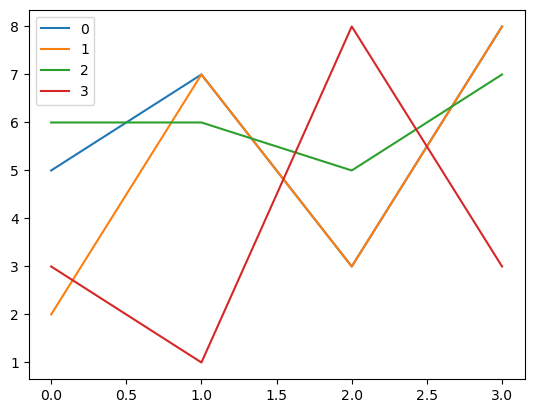

In [34]:
classwise_mean_grad = torch.randint(low=1, high=10, size=(10, 4))
cidx = [0, 1, 2, 3]
import matplotlib.pyplot as plt

for i, e in enumerate(cidx):
    plt.plot(classwise_mean_grad[i], label = e)
plt.legend()


In [28]:
classwise_mean_grad[i]

tensor([6, 7, 8])

In [1]:
a = [1, 2, 3]
b = [4, 5, 6]
a.extend(b)

In [2]:
a

[1, 2, 3, 4, 5, 6]

In [4]:
import torch
weight = torch.tensor(a)

c = weight[4:6]
c *= 10

weight

tensor([ 1,  2,  3,  4, 50, 60])

In [5]:
weight.data

tensor([ 1,  2,  3,  4, 50, 60])

In [1]:
import numpy as np

a = np.array([1, 2, 3, 1, 2, 3])
np.unique(a)

array([1, 2, 3])

In [7]:
m_dict = {s:[0 for c in [1, 2, 3, 4, 5]] for s in np.unique([1, 2])}


In [9]:
m_dict[1][a[1]]+=1

In [10]:
m_dict

{1: [0, 0, 1, 0, 0], 2: [0, 0, 0, 0, 0]}

In [13]:
np.sum([1, 2, 3])

6

In [3]:
params= {i:2*i for i in range(5)}
for k in params:
    print(f"\t\"{k}\" : \"{params[k]}\", \\")

	"0" : "0", \
	"1" : "2", \
	"2" : "4", \
	"3" : "6", \
	"4" : "8", \


In [2]:
0 // 10 == 0

True

In [ ]:
os.rename

In [12]:
# import os
# d = "outputs/dataset=MNIST/WA/no_metrics"
# for fol in os.listdir(d):
#     new_fol = fol[:-3]+'0.0'
#     print(new_fol)
#     os.rename(os.path.join(d, fol), os.path.join(d, new_fol))

seed=0_epoch=5_lr=0.01_tau=0.0
seed=0_epoch=5_lr=0.001_tau=0.0
seed=1_epoch=5_lr=0.01_tau=0.0
seed=1_epoch=5_lr=0.001_tau=0.0
seed=2_epoch=5_lr=0.01_tau=0.0
seed=2_epoch=5_lr=0.001_tau=0.0
seed=3_epoch=5_lr=0.01_tau=0.0
seed=3_epoch=5_lr=0.001_tau=0.0
seed=4_epoch=5_lr=0.01_tau=0.0
seed=4_epoch=5_lr=0.001_tau=0.0


In [3]:
import numpy as np
X = np.arange(12).reshape(3, 4)
train_index = np.array([0, 2])

In [4]:
X[train_index]

array([[ 0,  1,  2,  3],
       [ 8,  9, 10, 11]])

In [5]:
train_index

array([0, 2])

In [6]:
np.random.random()

0.773466550797758

In [9]:
import torch
import numpy as np
import copy

a = np.arange(10)
# a = torch.arange(10)
b = copy.deepcopy(a)

In [15]:
torch.stack([torch.from_numpy(a), torch.tensor(b)])

tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9]])

In [10]:
isinstance(a, np.ndarray)

True

In [12]:
torch.tensor(a)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [14]:
a = np.arange(1, 11)